## Importar librerías

In [32]:
import time
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

from mpl_toolkits.mplot3d import Axes3D

import pandas_ta as ta

from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interactive, fixed

## Cargar datos

In [2]:
def fetch_bitstamp_data(symbol, start, end, timeframe, limit=1000):
    url = f"https://www.bitstamp.net/api/v2/ohlc/{symbol}/"
    data_frames = []
    while start < end:
        # Ajustar end para la solicitud actual para no exceder el límite de 1000 registros
        current_end = start + (timeframe * limit)
        # Debug
        #print(f"{pd.to_datetime(start, unit='s')} - {pd.to_datetime(current_end, unit='s')}")
        params = {
            'start': int(start),
            'end': int(current_end),
            'step': timeframe,
            'limit': limit,
            'exclude_current_candle': False
        }
        try:
            response = requests.get(url, params=params)
            if response.status_code == 200:
                data = response.json()
                df = pd.DataFrame(data['data']['ohlc'])
                if not df.empty:
                    data_frames.append(df)
            else:
                raise Exception(f"Failed to fetch data: {response.status_code}, {response.text}")
        except Exception as e:
            print(e)
            break
        start = current_end
    # Combinar todos los DataFrames
    if data_frames:
        df = pd.concat(data_frames, ignore_index=True)
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
        df = df.set_index('timestamp')
        df = df.sort_index()
        df.index.name = 'date'
        df = df.astype({
            'open': float,
            'high': float,
            'low': float,
            'close': float,
            'volume': float
        })
        # Comprobar filas duplicadas
        if df.index.duplicated().any():
            df = df[~df.index.duplicated(keep='first')]
        return df
    else:
        return pd.DataFrame()
# Descarga de históricos OHLCV
start_date = pd.Timestamp('2014-01-01').timestamp()
end_date = pd.Timestamp.now(tz='UTC').timestamp()
df = fetch_bitstamp_data('btcusd', start=start_date, end=end_date, timeframe=300)

## Análisis exploratorio de datos

In [3]:
df.shape

(1122859, 5)

In [4]:
df.describe

<bound method NDFrame.describe of                          open      high       low     close      volume
date                                                                   
2014-01-01 00:05:00    733.70    734.34    730.33    733.70   19.984570
2014-01-01 00:10:00    733.70    734.50    733.70    734.50   20.442605
2014-01-01 00:15:00    734.50    735.00    732.19    732.19   34.476090
2014-01-01 00:20:00    732.19    738.00    731.81    731.99  127.534128
2014-01-01 00:25:00    738.10    738.25    734.56    734.81    5.763070
...                       ...       ...       ...       ...         ...
2024-09-03 19:15:00  58120.00  58120.00  58060.00  58106.00    2.731894
2024-09-03 19:20:00  58135.00  58232.00  58135.00  58201.00    2.023977
2024-09-03 19:25:00  58095.00  58095.00  58006.00  58006.00    0.432301
2024-09-03 19:30:00  58034.00  58034.00  57902.00  57939.00    6.503275
2024-09-03 19:35:00  57906.00  57906.00  57860.00  57878.00    9.659338

[1122859 rows x 5 columns]>

## Preparación de datos

In [5]:
# Limpieza de datos
if df.isnull().values.any():
    df[df.columns.values] = df[df.columns.values].ffill()

In [6]:
# Eliminar índice de tiempo
df = df.reset_index(drop=True)

## Establecer la señal de clasificación

In [7]:
# Crear una media móvil corta
df['short_mavg'] = ta.ma('sma', df['close'], length=10)
# Crear una media móvil larga
df['long_mavg'] = ta.ma('sma', df['close'], length=60)
# Crear señal de trading
df['signal'] = np.where(df['short_mavg'] > df['long_mavg'], 1.0, 0.0)

In [8]:
df.tail()

,open,high,low,close,volume,short_mavg,long_mavg,signal
1122854,58120.0,58120.0,58060.0,58106.0,2.731894,58006.0,57819.483333,1.0
1122855,58135.0,58232.0,58135.0,58201.0,2.023977,58026.8,57822.450000,1.0
1122856,58095.0,58095.0,58006.0,58006.0,0.432301,58027.7,57823.683333,1.0
1122857,58034.0,58034.0,57902.0,57939.0,6.503275,58023.8,57824.650000,1.0
1122858,57906.0,57906.0,57860.0,57878.0,9.659338,58013.0,57825.100000,1.0


## Ingeniería de características

In [9]:
# Cálculo de 3 medias móviles exponenciales
df['ema10'] = ta.ma('ema', df['close'], length=10)
df['ema30'] = ta.ma('ema', df['close'], length=30)
df['ema200'] = ta.ma('ema', df['close'], length=200)
# Cálculo de Rate Of Change
df['roc10'] = ta.roc(df['close'], length=10)
df['roc30'] = ta.roc(df['close'], length=30)
# Cálculo de Price Momentum
df['mom10'] = ta.mom(df['close'], length=10)
df['mom30'] = ta.mom(df['close'], length=30)
# Cálculo de Relative Strength Index
df['rsi10'] = ta.rsi(df['close'], length=10)
df['rsi30'] = ta.rsi(df['close'], length=30)
df['rsi200'] = ta.rsi(df['close'], length=200)
# Calcular el oscilador estocástico %K y %D
df[['k10', 'd10']] = ta.stoch(high=df['high'], low=df['low'], close=df['close'], k=10, d=3)
df[['k30', 'd30']] = ta.stoch(high=df['high'], low=df['low'], close=df['close'], k=30, d=3)
df[['k200', 'd200']] = ta.stoch(high=df['high'], low=df['low'], close=df['close'], k=200, d=3)
# Ver dataframe resultante
df.tail()


,open,high,low,close,volume,short_mavg,long_mavg,signal,ema10,ema30,...,mom30,rsi10,rsi30,rsi200,k10,d10,k30,d30,k200,d200
1122854,58120.0,58120.0,58060.0,58106.0,2.731894,58006.0,57819.483333,1.0,57998.334508,57912.931258,...,324.0,66.158361,53.066211,48.181626,93.466754,87.595517,94.528140,88.317786,26.097255,22.999333
1122855,58135.0,58232.0,58135.0,58201.0,2.023977,58026.8,57822.450000,1.0,58035.182779,57931.516338,...,543.0,71.414729,55.298605,48.603370,92.091674,92.406033,95.839389,93.717205,29.853872,26.491974
1122856,58095.0,58095.0,58006.0,58006.0,0.432301,58027.7,57823.683333,1.0,58029.876819,57936.321736,...,318.0,52.734008,50.225819,47.800790,70.920073,85.492834,84.925737,91.764422,28.324635,28.091921
1122857,58034.0,58034.0,57902.0,57939.0,6.503275,58023.8,57824.650000,1.0,58013.353761,57936.494527,...,248.0,47.945990,48.639873,47.529768,45.919371,69.643706,71.838198,84.201108,25.909300,28.029269
1122858,57906.0,57906.0,57860.0,57878.0,9.659338,58013.0,57825.100000,1.0,57988.743986,57932.720686,...,170.0,43.912630,47.235106,47.284456,17.247122,44.695522,55.299539,70.687825,20.737646,24.990527


In [10]:
# Excluir las características no necesarias para la predicción
df = df.drop(columns=['high', 'low', 'open', 'short_mavg', 'long_mavg'], axis=1)

In [11]:
# Limpiar dataframe
df = df.dropna(axis=0)

## Visualización de datos

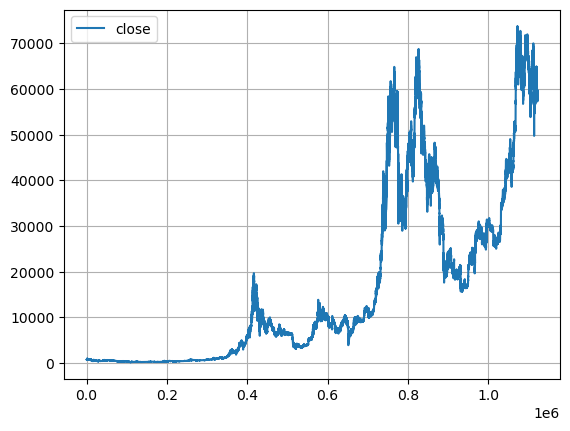

In [12]:
df[['close']].plot(grid=True)
plt.show()

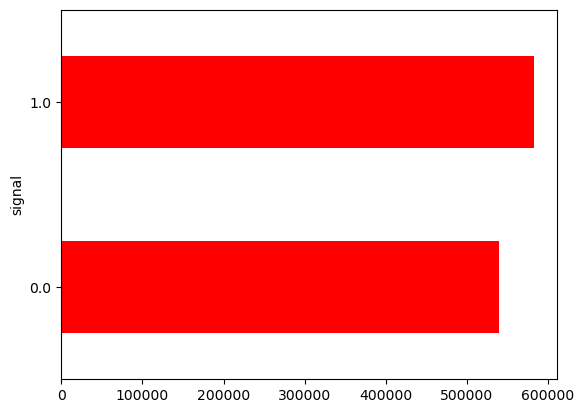

In [13]:
fig = plt.figure()
plot = df.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

## Evaluación de Modelos y Algoritmos

In [14]:
# División de datos en entrenamiento y validación
subset_df = df.iloc[-10000:]
Y = subset_df['signal']
X = subset_df.loc[:, df.columns != 'signal']
validation_size = 0.2
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, shuffle=True)

In [15]:
# Estandarización de datos
scaler = StandardScaler().fit(X_train)
rescaled_df = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_train = X_train.dropna(how='any')
rescaled_df = rescaled_df.dropna(how='any')

### Reducción de características

Varianza preservada por los 5 componentes == 90.21%


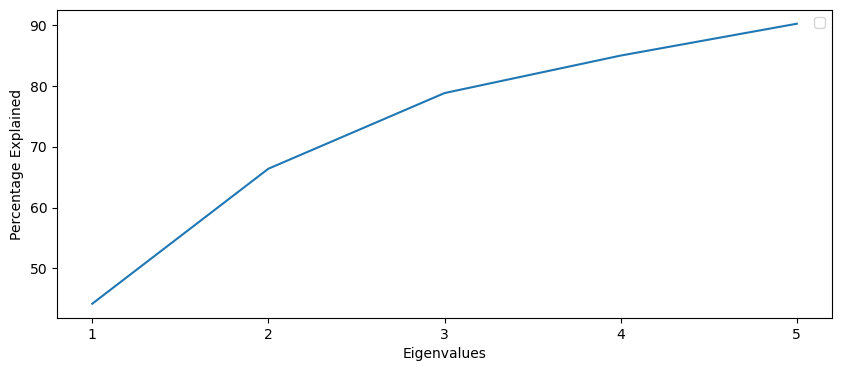

In [16]:
# Singular Value Decomposition (Dimensionality reduction)
ncomps = 5
svd = TruncatedSVD(n_components=ncomps)
svd_fit = svd.fit(rescaled_df)
plt_data = pd.DataFrame(svd_fit.explained_variance_ratio_.cumsum() * 100.)
plt_data.index = np.arange(1, len(plt_data) + 1)
Y_pred = svd.transform(rescaled_df)
ax = plt_data.plot(kind='line', figsize=(10, 4))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel('Eigenvalues')
ax.set_ylabel('Percentage Explained')
ax.legend('')
print("Varianza preservada por los 5 componentes == {:.2%}".format(svd_fit.explained_variance_ratio_.cumsum()[-1]))

In [17]:
# Crear dataframe con los eigenvalues
dfsvd = pd.DataFrame(Y_pred, columns=[f'c{c}' for c in range(ncomps)], index=rescaled_df.index)
dfsvd.head()

,c0,c1,c2,c3,c4
1117940,0.163394,-0.334996,2.006821,-0.043496,-0.281224
1114768,4.255865,-2.774736,0.952620,-0.011448,-0.425843
1121476,-0.778508,-0.530857,-0.854945,-0.945109,0.365766
1118047,2.957069,-0.483138,-0.023613,1.506730,-0.264968
1114673,-2.751234,-4.184654,1.111123,3.039759,0.939317


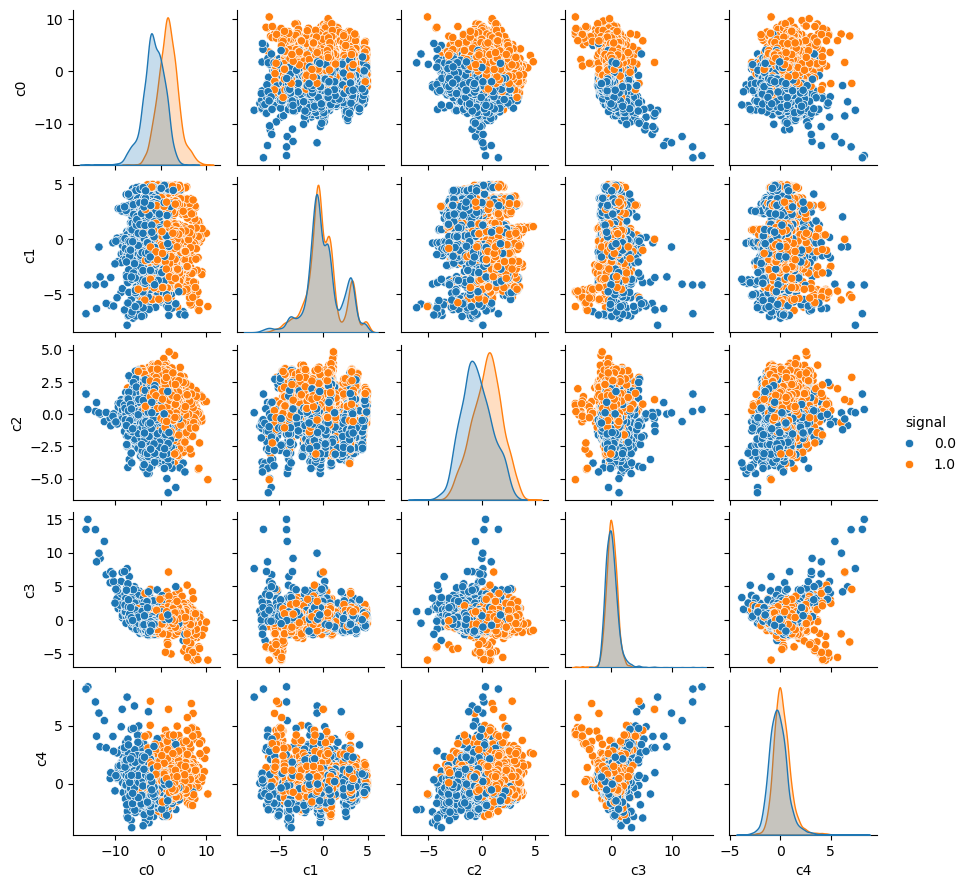

In [18]:
# Visualización por pares
dfsvdplot = dfsvd.copy()
dfsvdplot['signal'] = Y_train
ax = sns.pairplot(dfsvdplot, hue='signal', size=1.8)
plt.show()

In [19]:
# 3D scatterplot
def scatter_3D(A, elevation=30, azimuth=120):
    maxpts = 1000
    fig = plt.figure(figsize=(9, 9))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=elevation, azim=azimuth)
    ax.set_xlabel('component 0')
    ax.set_ylabel('Component 1')
    ax.set_zlabel('component 2')

    # Plot subset of points
    rndpts = np.sort(np.random.choice(A.shape[0], min(maxpts, A.shape[0]), replace=False))
    coloridx = np.unique(A.iloc[rndpts]['signal'], return_inverse=True)
    colors = coloridx[1] / len(coloridx[0])

    ax.scatter(A.iloc[rndpts, 0], A.iloc[rndpts, 1], A.iloc[rndpts, 2],
               c=colors, cmap='jet', marker='o', alpha=0.6, s=50,
               linewidths=0.8, edgecolor='#BBBBBB')
    plt.show()

In [20]:
interactive_plot = interactive(scatter_3D, A=fixed(dfsvdplot), elevation=(0, 90), azimuth=(0, 360))
interactive_plot

interactive(children=(IntSlider(value=30, description='elevation', max=90), IntSlider(value=120, description='…

In [21]:
# t-SNE (Dimensionality reduction)
tsne = TSNE(n_components=2, random_state=0)

In [22]:
Z = tsne.fit_transform(dfsvd)
dftsne = pd.DataFrame(Z, columns=['x', 'y'], index=dfsvd.index)
dftsne['signal'] = Y_train

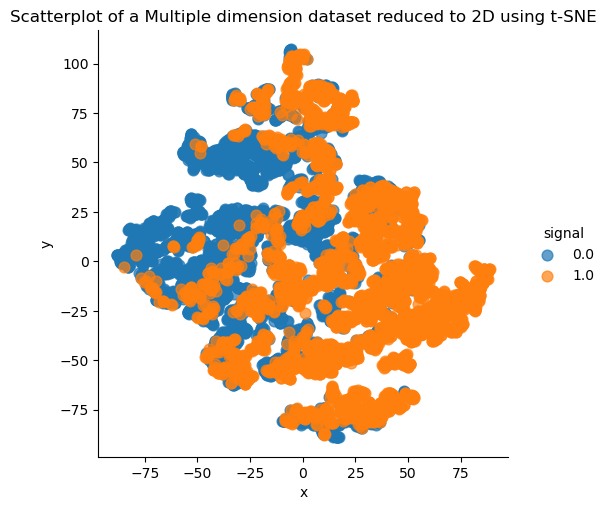

In [28]:
g = sns.lmplot(data=dftsne, x='x', y='y', hue='signal', fit_reg=False,
                scatter_kws={'alpha':0.7, 's':60})
g.axes.flat[0].set_title('Scatterplot of a Multiple dimension dataset reduced to 2D using t-SNE')
plt.show()

In [35]:
# Comparación de entrenamiento con y sin reducción de dimensionalidad
scoring = 'accuracy'
kfold = KFold(n_splits=5)
models = GradientBoostingClassifier()

In [41]:
start_time = time.time()
cv_results_XTrain = cross_val_score(models, X_train, Y_train, cv=kfold, scoring=scoring)
print("Time Without Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))

Time Without Dimensionality Reduction--- 18.950949907302856 seconds ---


In [43]:
X_SVD = dfsvd.copy()
start_time = time.time()
cv_results_SVD = cross_val_score(models, X_SVD, Y_train, cv=kfold, scoring=scoring)
print("Time with Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))

Time with Dimensionality Reduction--- 6.092670917510986 seconds ---


In [44]:
print("Result without dimensionality Reduction: %f (%f)" % (cv_results_XTrain.mean(), cv_results_XTrain.std()))
print("Result with dimensionality Reduction: %f (%f)" % (cv_results_SVD.mean(), cv_results_SVD.std()))

Result without dimensionality Reduction: 0.918125 (0.005405)
Result with dimensionality Reduction: 0.865375 (0.006232)
